In [ ]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes nlpaug
!pip install nvidia-ml-py3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import (
    RobertaModel, RobertaTokenizer, RobertaPreTrainedModel,
    RobertaForSequenceClassification, AutoConfig, TrainingArguments,
    Trainer, DataCollatorWithPadding, EarlyStoppingCallback
)
from peft import LoraConfig, get_peft_model
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import evaluate
from tqdm import tqdm

In [ ]:
# === Configuration variables ===

# Specify the base model to use for fine-tuning
model_name = "roberta-base"

# Directory where the fine-tuned model will be saved
model_save_dir = "fine_tuned_model"

# Set to True if you want to use a custom classification head on top of the base model
use_custom_head = False

# Enable early stopping to prevent overfitting during training
use_early_stopping = True

# Apply weight decay regularization to the optimizer
use_weight_decay = False

# Freeze the base model layers to train only the classification head
freeze_base_model = True

# Number of evaluation steps with no improvement after which training stops (only if early stopping is enabled)
early_stopping_patience = 3

# Value for weight decay if use_weight_decay is True
weight_decay_val = 0.01

# Number of forward passes for MC Dropout (used only if use_mc_dropout is True)
mc_dropout_passes = 10

# Number of final layers in the base model to unfreeze (if freeze_base_model is False or partially unfreezing)
unfreeze_last_layers = 2

# Maximum number of tokens allowed in each input sequence
max_seq_length = 128

# Batch size used during training
train_batch_size = 32

# Batch size used during evaluation
eval_batch_size = 64

# Total number of training epochs
num_epochs = 2

# Learning rate for the optimizer
learning_rate = 5e-6


In [ ]:
# === Load the AG News dataset ===
# This will download and prepare the dataset for use (train and test splits)
dataset = load_dataset("ag_news")

# === Load the tokenizer for the specified model ===
# This tokenizer will be used to convert raw text into token IDs compatible with RoBERTa
tokenizer = RobertaTokenizer.from_pretrained(model_name)

# === Set the maximum sequence length for tokenization ===
# Ensures all tokenized sequences are truncated or padded to this fixed length
tokenizer.model_max_length = max_seq_length


In [ ]:
base_model = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(base_model)

# Load dataset
dataset = load_dataset('ag_news')  # This loads both 'train' and 'test' splits

# Optional: max length (if you want fixed-length padding, set this to a value like 128)
max_seq_length = None  # Set to an int like 128 for fixed padding, or None for dynamic

# Tokenization function
def preprocess(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length" if max_seq_length else True,
        max_length=max_seq_length
    )

# Tokenize datasets
train_data = dataset["train"].map(preprocess, batched=True, remove_columns=["text"])
test_data = dataset["test"].map(preprocess, batched=True, remove_columns=["text"])

# Rename 'label' to 'labels' as required by HuggingFace models
train_data = train_data.rename_column("label", "labels")
test_data = test_data.rename_column("label", "labels")

# Get label info
num_labels = dataset["train"].features["label"].num_classes
label_names = dataset["train"].features["label"].names
id2label = {i: l for i, l in enumerate(label_names)}
label2id = {l: i for i, l in enumerate(label_names)}

# Data collator for dynamic padding (best for GPU memory and speed)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:

training_args = TrainingArguments(
    output_dir=f"./outputs/{model_save_dir}",         # Directory to save model checkpoints and logs
    report_to="none",                                 # Disable logging to external tools like WandB or TensorBoard
    eval_strategy="steps",                            # Evaluate the model every few steps
    save_strategy="steps",                            # Save checkpoints every few steps
    eval_steps=500,                                   # Perform evaluation every 500 steps
    save_steps=4000,                                  # Save a model checkpoint every 4000 steps
    logging_steps=500,                                # Log training metrics every 500 steps
    learning_rate=learning_rate,                      # Initial learning rate for the optimizer
    per_device_train_batch_size=train_batch_size,     # Batch size per device (GPU/CPU) during training
    per_device_eval_batch_size=eval_batch_size,       # Batch size per device during evaluation
    num_train_epochs=num_epochs,                      # Total number of training epochs
    weight_decay=weight_decay_val if use_weight_decay else 0.0,  # Apply weight decay if enabled
    save_total_limit=3,                               # Keep only the latest 3 model checkpoints
    load_best_model_at_end=True,                      # Load the best checkpoint at the end of training
    metric_for_best_model="accuracy",                 # Use accuracy to select the best model
    greater_is_better=True,                           # Higher accuracy is better
    lr_scheduler_type="linear",                       # Linear learning rate scheduler with warmup
    warmup_ratio=0.1                                  # Warmup for 10% of total training steps
)



In [ ]:
class CustomRobertaClassifier(RobertaPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)

        # Load pre-trained RoBERTa model as the encoder
        self.roberta = RobertaModel(config)

        # Define a custom multi-layer classifier head
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size, 512),  # First linear layer from hidden size to 512
            nn.LayerNorm(512),                   # Layer normalization
            nn.GELU(),                           # GELU activation function
            nn.Dropout(0.3),                     # Dropout for regularization

            nn.Linear(512, 256),                 # Second linear layer from 512 to 256
            nn.LayerNorm(256),                   # Layer normalization
            nn.GELU(),                           # GELU activation function
            nn.Dropout(0.3),                     # Dropout for regularization

            nn.Linear(256, config.num_labels)    # Final linear layer mapping to number of labels
        )

        self.init_weights()  # Initialize weights for the custom layers

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        # Get hidden states from RoBERTa
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)

        # Use the [CLS] token's representation (first token) for classification
        cls_token = outputs.last_hidden_state[:, 0]

        # Pass the [CLS] token through the custom classifier
        logits = self.classifier(cls_token)

        loss = None
        if labels is not None:
            # Compute cross-entropy loss with label smoothing
            loss_fct = nn.CrossEntropyLoss(label_smoothing=0.1)
            loss = loss_fct(logits, labels)

        # Return loss and logits during training, or just logits during inference
        return {"loss": loss, "logits": logits} if loss is not None else {"logits": logits}


In [ ]:
base_model = RobertaForSequenceClassification.from_pretrained(
    model_name,              # Name of the pre-trained RoBERTa model to load
    num_labels=num_labels,   # Total number of target labels for classification
    id2label=id2label,       # Mapping from label IDs to label names (for readability in outputs)
    label2id=label2id        # Mapping from label names to label IDs (used internally during training)
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
lora_config = LoraConfig(
    r=3,                                      # Rank of the LoRA update matrices (controls parameter efficiency)
    lora_alpha=5,                             # Scaling factor for LoRA updates
    lora_dropout=0.05,                        # Dropout probability applied to LoRA layers during training
    bias='none',                              # No bias adjustment in LoRA layers
    target_modules=["query", "value"],        # Apply LoRA to attention query and value projection layers
    task_type="SEQ_CLS"                       # Task type is sequence classification
)

# Wrap the base model with the LoRA configuration for parameter-efficient fine-tuning
model = get_peft_model(base_model, lora_config)


In [ ]:
model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): Mo

In [ ]:
print('PEFT Model')
model.print_trainable_parameters()

PEFT Model
trainable params: 704,260 || all params: 125,352,968 || trainable%: 0.5618


In [ ]:
# Function to compute evaluation metrics after each evaluation phase
def compute_metrics(eval_pred):
    predictions = eval_pred.predictions.argmax(-1)  # Get the predicted class index with highest logit
    return {"accuracy": accuracy_score(eval_pred.label_ids, predictions)}  # Return accuracy score

# Configure early stopping callback if enabled
callbacks = [EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)] if use_early_stopping else []
# This stops training if no improvement in validation metric for 'early_stopping_patience' evaluations


In [ ]:
trainer = Trainer(
    model=model,                           # The model to be trained (with or without LoRA)
    args=training_args,                    # Training arguments including batch size, epochs, LR, etc.
    train_dataset=train_data,              # Dataset used for training
    eval_dataset=test_data,                # Dataset used for evaluation during training
    tokenizer=tokenizer,                   # Tokenizer used for preprocessing text inputs
    data_collator=data_collator,           # Handles dynamic padding and batching of inputs
    compute_metrics=compute_metrics,       # Function to compute evaluation metrics like accuracy
    callbacks=callbacks                    # Optional callbacks (e.g., early stopping)
)


<ipython-input-46-61a56f6058c8>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
# train the custom model
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
500,1.392100,1.380900,0.250000
1000,1.366300,1.341744,0.771053
1500,1.260600,1.108616,0.880263
2000,0.727100,0.418497,0.881711
2500,0.392700,0.340645,0.889868
3000,0.344000,0.325600,0.891711
3500,0.332900,0.318263,0.892500
4000,0.328500,0.313094,0.894868
4500,0.319100,0.309989,0.895132
5000,0.314900,0.308003,0.895789


TrainOutput(global_step=7500, training_loss=0.5553366536458333, metrics={'train_runtime': 2518.6576, 'train_samples_per_second': 95.289, 'train_steps_per_second': 2.978, 'total_flos': 4.224507662223514e+16, 'train_loss': 0.5553366536458333, 'epoch': 2.0})

In [ ]:
def evaluate_model(model, dataset, with_labels=True, batch_size=8, collator=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collator)
    preds = []
    true = []
    if with_labels:
        metric = evaluate.load("accuracy")
    for batch in tqdm(loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            out = model(**batch)
        pred = out.logits.argmax(dim=-1)
        preds.append(pred.cpu())
        if with_labels:
            metric.add_batch(predictions=pred.cpu().numpy(), references=batch["labels"].cpu().numpy())
            true.append(batch["labels"].cpu())
    all_preds = torch.cat(preds)
    all_true = torch.cat(true)
    if with_labels:
        result = metric.compute()
        print("Accuracy:", result)
        return result, all_preds, all_true
    return all_preds, None

# === Evaluate Model ===
_, all_preds, all_true = evaluate_model(model, test_data, True, eval_batch_size, data_collator)

# === Training Metrics: Accuracy vs Steps & Steps vs Loss ===
training_history = trainer.state.log_history

steps = []
losses = []
accuracies = []

for record in training_history:
    if "loss" in record and "step" in record:
        steps.append(record["step"])
        losses.append(record["loss"])
    if "eval_accuracy" in record and "step" in record:
        accuracies.append((record["step"], record["eval_accuracy"]))



100%|██████████| 119/119 [00:19<00:00,  6.05it/s]


Accuracy: {'accuracy': 0.8985526315789474}


# Plot Accuracy vs Steps

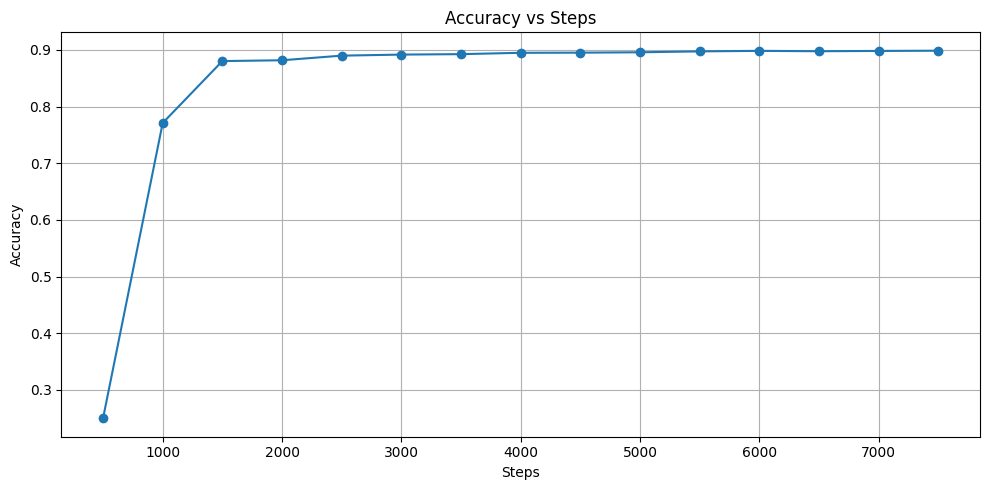

In [ ]:
acc_steps, acc_values = zip(*accuracies)
plt.figure(figsize=(10, 5))
plt.plot(acc_steps, acc_values, marker='o')
plt.title("Accuracy vs Steps")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

# plot of Steps vs Loss

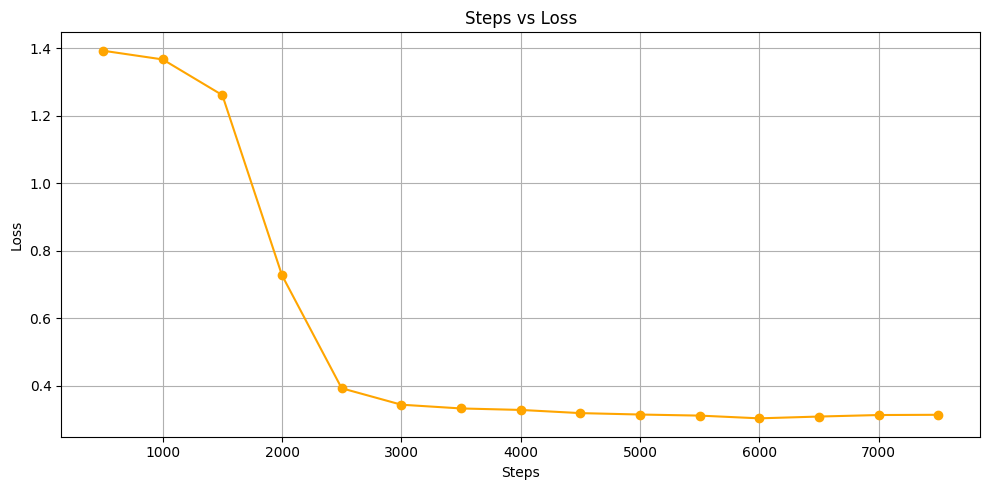

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, color='orange', marker='o')
plt.title("Steps vs Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


# Confusion Matrix

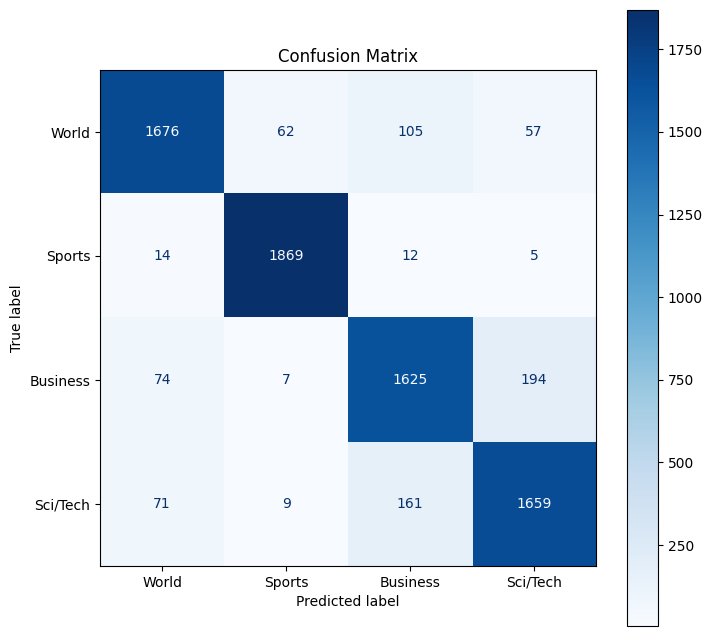

In [ ]:

# === Confusion Matrix ===
cm = confusion_matrix(all_true, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


# Plot of Predicted Class Distribution

<ipython-input-80-97642463bd3a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=all_preds.numpy(), palette='viridis')


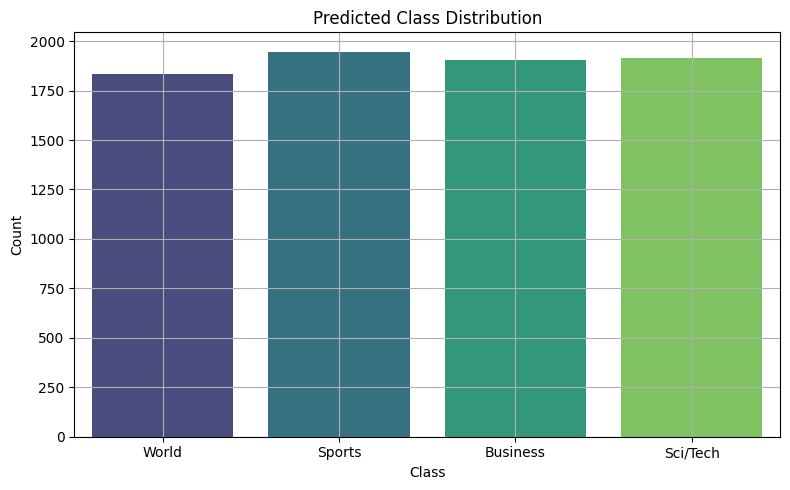

In [ ]:
# === Predicted Class Distribution ===
plt.figure(figsize=(8, 5))
sns.countplot(x=all_preds.numpy(), palette='viridis')
plt.title("Predicted Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=range(num_labels), labels=label_names)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
unlabelled_dataset = pd.read_pickle(r"/content/test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 8000
})

In [ ]:
def predict(model, dataset, with_labels=True, batch_size=8, collator=None):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collator)
    preds = []
    true = []

    with torch.no_grad():
        for batch in dataloader:
            # Move inputs to device
            inputs = {k: v.to(model.device) for k, v in batch.items() if k != "labels"}
            outputs = model(**inputs)
            logits = outputs.logits
            preds.append(torch.argmax(logits, dim=1).cpu())

            # Collect true labels only if available
            if with_labels and "labels" in batch:
                true.append(batch["labels"].cpu())

    all_preds = torch.cat(preds)

    if with_labels:
        if len(true) > 0:
            all_true = torch.cat(true)
            return all_preds, all_true
        else:
            return all_preds, None
    else:
        return all_preds


In [ ]:
# Run inference and save predictions
preds = predict(model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})

df_output.to_csv(os.path.join(r"/content/outputs/fine_tuned_model","4.csv"), index=False)
print("Inference complete. Predictions saved to inference_output.csv")

Inference complete. Predictions saved to inference_output.csv


In [ ]:
#### save model #####
model.save_pretrained(f"./outputs/{model_save_dir}/final_model")
tokenizer.save_pretrained(f"./outputs/{model_save_dir}/final_model")

('./outputs/fine_tuned_model/final_model/tokenizer_config.json',
 './outputs/fine_tuned_model/final_model/special_tokens_map.json',
 './outputs/fine_tuned_model/final_model/vocab.json',
 './outputs/fine_tuned_model/final_model/merges.txt',
 './outputs/fine_tuned_model/final_model/added_tokens.json')